In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.random.seed(42)

In [20]:
# CHARGEMENT DU DATASET
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X, y = data.data, data.target
print("Données chargées avec succès.")
print(f"Forme : {X.shape[0]} lignes, {X.shape[1]} colonnes")
print(f"Variables : {data.feature_names}")


Données chargées avec succès.
Forme : 20640 lignes, 8 colonnes
Variables : ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# ***ANALYSE INITIALE***


 Statistiques des variables explicatives :
                Moyenne   Écart-type         Min           Max
MedInc         3.870671     1.899776    0.499900     15.000100
HouseAge      28.639486    12.585253    1.000000     52.000000
AveRooms       5.429000     2.474113    0.846154    141.909091
AveBedrms      1.096675     0.473899    0.333333     34.066667
Population  1425.476744  1132.434688    3.000000  35682.000000
AveOccup       3.070655    10.385798    0.692308   1243.333333
Latitude      35.631861     2.135901   32.540000     41.950000
Longitude   -119.569704     2.003483 -124.350000   -114.310000

 Prix médian (cible) :
  Min = 0.15 | Max = 5.00 | Moyenne = 2.07

 Valeurs manquantes : 0 dans X, 0 dans y


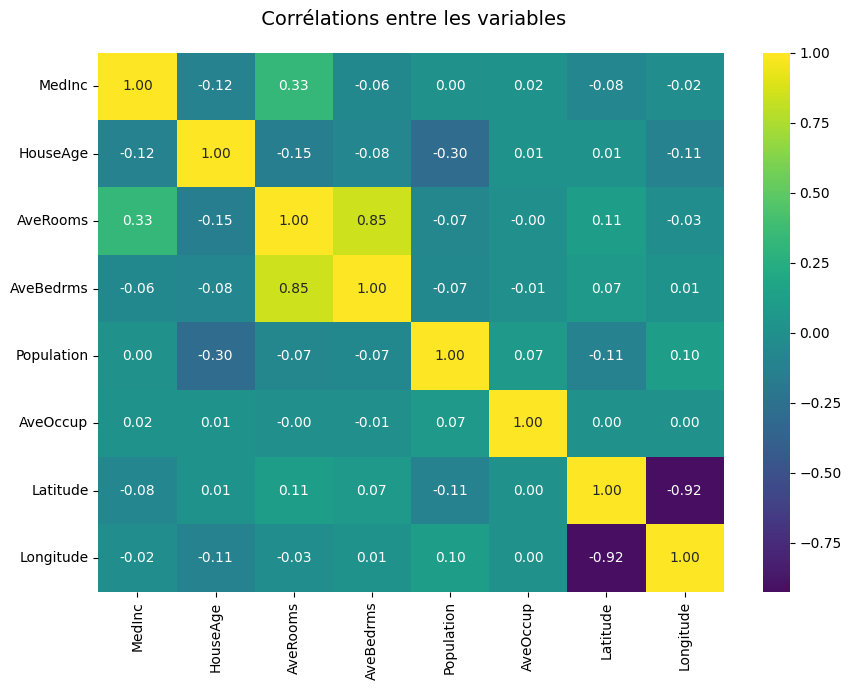

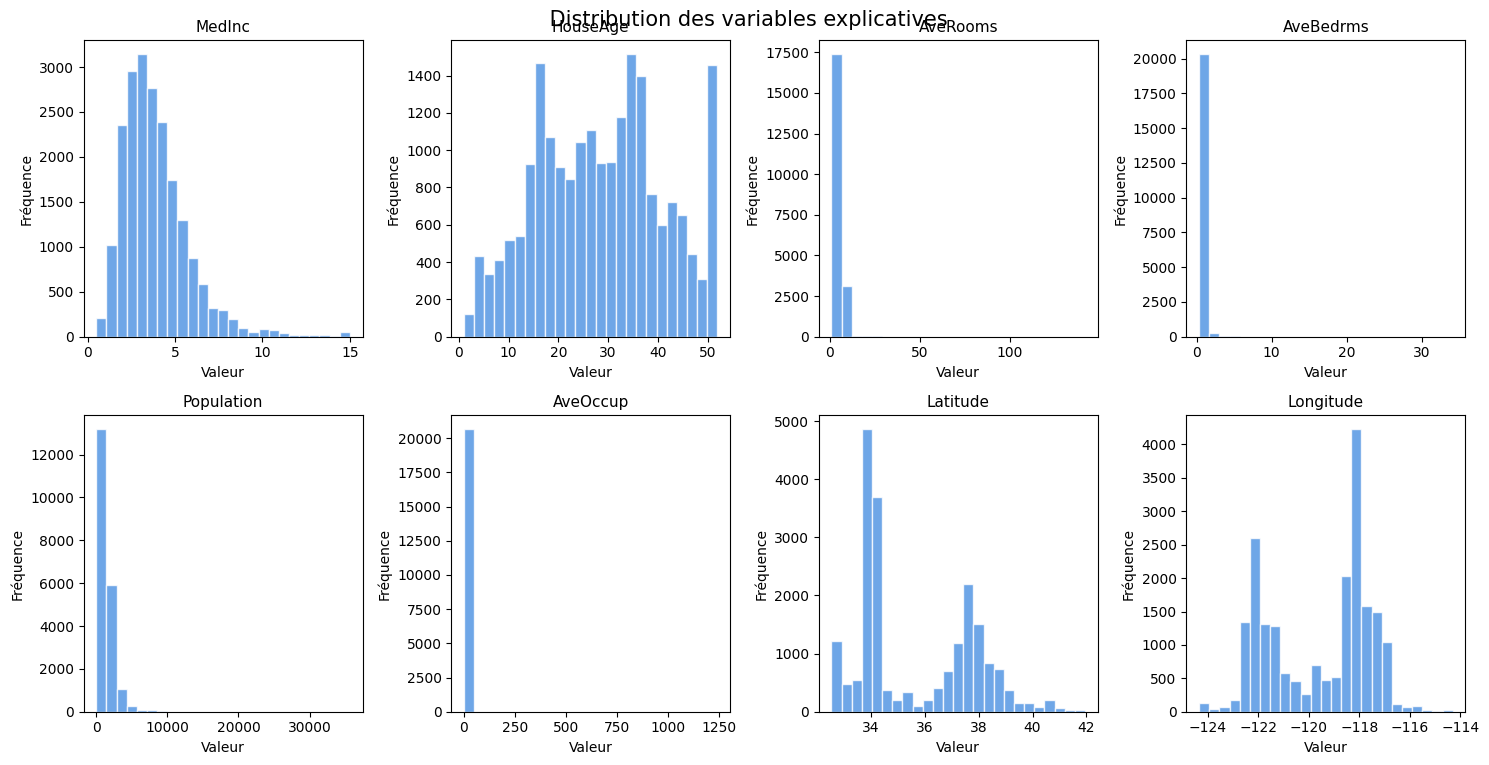

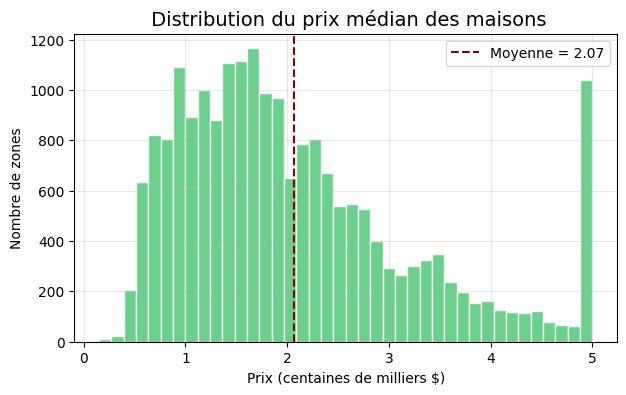

In [21]:
# Statistiques des features
desc_X = pd.DataFrame({
    "Moyenne": np.mean(X, axis=0),
    "Écart-type": np.std(X, axis=0),
    "Min": np.min(X, axis=0),
    "Max": np.max(X, axis=0)
}, index=data.feature_names)
print("\n Statistiques des variables explicatives :")
print(desc_X)

# Statistiques de la cible
print(f"\n Prix médian (cible) :")
print(f"  Min = {y.min():.2f} | Max = {y.max():.2f} | Moyenne = {y.mean():.2f}")

# Vérification des données manquantes
print(f"\n Valeurs manquantes : {np.isnan(X).sum().sum()} dans X, {np.isnan(y).sum()} dans y")

# Matrice de corrélation
plt.figure(figsize=(9, 7))
sns.heatmap(
    np.corrcoef(X, rowvar=False),
    annot=True,
    xticklabels=data.feature_names,
    yticklabels=data.feature_names,
    cmap="viridis",
    center=0,
    fmt=".2f"
)
plt.title(" Corrélations entre les variables", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Distribution des features
plt.figure(figsize=(15, 8))
for i, name in enumerate(data.feature_names):
    plt.subplot(2, 4, i+1)
    plt.hist(X[:, i], bins=25, color='#4A90E2', alpha=0.8, edgecolor='white')
    plt.title(name, fontsize=11)
    plt.xlabel('Valeur')
    plt.ylabel('Fréquence')
plt.suptitle(" Distribution des variables explicatives", fontsize=15, y=0.95)
plt.tight_layout()
plt.show()

# Distribution de la cible
plt.figure(figsize=(7, 4))
plt.hist(y, bins=40, color='#50C878', alpha=0.85, edgecolor='white')
plt.axvline(y.mean(), color='darkred', linestyle='--', label=f'Moyenne = {y.mean():.2f}')
plt.title(" Distribution du prix médian des maisons", fontsize=14)
plt.xlabel("Prix (centaines de milliers $)")
plt.ylabel("Nombre de zones")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [22]:

X_raw, y_raw = X.copy(), y.copy()
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

# Séparation train/validation
n_total = len(X)
n_train = int(0.8 * n_total)
indices = np.random.permutation(n_total)
X_train, y_train = X[indices[:n_train]], y[indices[:n_train]]
X_val, y_val = X[indices[n_train:]], y[indices[n_train:]]

n, d = X_train.shape
print(f"\n Préparation terminée : {n} exemples d'entraînement, {d} variables.")


 Préparation terminée : 16512 exemples d'entraînement, 8 variables.


### ***Outil : Calcul de la constante de Lipschitz***


In [23]:
def power_iteration(A, max_iter=100):
    b = np.random.rand(A.shape[1])
    for _ in range(max_iter):
        b = A @ b
        norm_b = np.linalg.norm(b)
        if norm_b == 0: return 0
        b /= norm_b
    return b.T @ A @ b

L = power_iteration(X_train.T @ X_train) / n
alpha_opt = 1.0 / L
print(f"\n Pas optimal estimé : α = {alpha_opt:.6f}")


 Pas optimal estimé : α = 0.505613


# ***2 – Optimisation différentiable et méthodes de gradient***

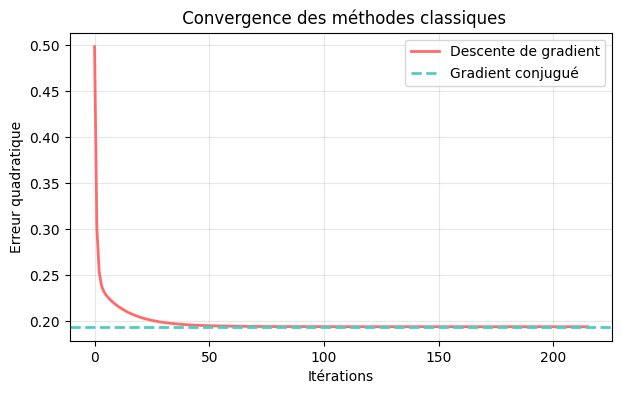

In [24]:
def gradient_descent_batch(X, y, alpha, max_iter=500):
    w = np.zeros(X.shape[1])
    losses = []
    for k in range(max_iter):
        residual = X @ w - y
        loss = 0.5 * np.mean(residual**2)
        losses.append(loss)
        grad = (X.T @ residual) / len(X)
        w -= alpha * grad
        if k > 0 and abs(losses[-2] - loss) < 1e-8:
            break
    return w, losses

def conjugate_gradient(X, y, max_iter=None):
    if max_iter is None: max_iter = X.shape[1]
    A = X.T @ X / len(X)
    b = X.T @ y / len(X)
    w = np.zeros_like(b)
    r = b - A @ w
    p = r.copy()
    for k in range(max_iter):
        Ap = A @ p
        if np.dot(p, Ap) == 0: break
        alpha_cg = np.dot(r, r) / np.dot(p, Ap)
        w += alpha_cg * p
        r_new = r - alpha_cg * Ap
        if np.linalg.norm(r_new) < 1e-8: break
        beta = np.dot(r_new, r_new) / np.dot(r, r)
        p = r_new + beta * p
        r = r_new
    loss = 0.5 * np.mean((X @ w - y)**2)
    return w, loss

w_gd, loss_gd = gradient_descent_batch(X_train, y_train, alpha_opt)
w_cg, loss_cg = conjugate_gradient(X_train, y_train)

plt.figure(figsize=(7, 4))
plt.plot(loss_gd, color='#FF6B6B', linewidth=2, label='Descente de gradient')
plt.axhline(loss_cg, color='#4ECDC4', linestyle='--', linewidth=2, label='Gradient conjugué')
plt.xlabel("Itérations")
plt.ylabel("Erreur quadratique")
plt.title(" Convergence des méthodes classiques")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ***3 - Gradient stochastique***

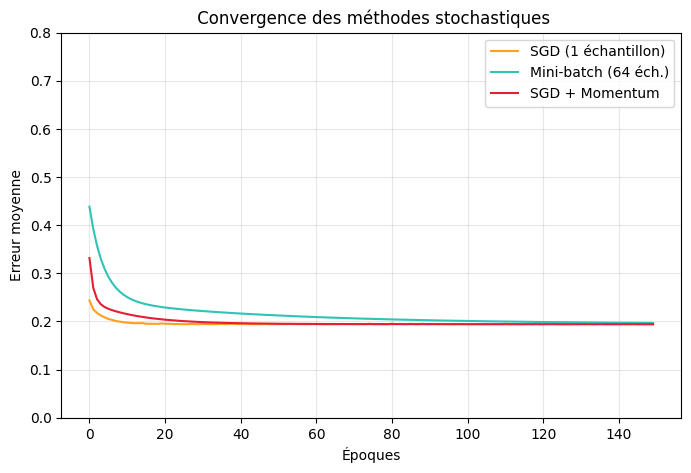

In [25]:
def sgd_custom(X, y, lr, batch_size=1, momentum=0.0, epochs=100):
    w = np.zeros(X.shape[1])
    v = np.zeros_like(w)
    losses = []
    for epoch in range(epochs):
        idx = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            batch = idx[i:i+batch_size]
            Xb, yb = X[batch], y[batch]
            grad = (Xb.T @ (Xb @ w - yb)) / len(batch)
            if momentum > 0:
                v = momentum * v + lr * grad
                w -= v
            else:
                w -= lr * grad
        loss = 0.5 * np.mean((X @ w - y)**2)
        if not np.isfinite(loss) or loss > 5: break
        losses.append(loss)
    return w, losses

# Entraînement
w_sgd, loss_sgd = sgd_custom(X_train, y_train, lr=0.0001, batch_size=1, epochs=150)
w_mb,  loss_mb  = sgd_custom(X_train, y_train, lr=0.0005, batch_size=64, epochs=150)
w_mom, loss_mom = sgd_custom(X_train, y_train, lr=0.0002, batch_size=64, momentum=0.9, epochs=150)

plt.figure(figsize=(8, 5))
plt.plot(loss_sgd, color='#FF9F1C', label='SGD (1 échantillon)')
plt.plot(loss_mb,  color='#2EC4B6', label='Mini-batch (64 éch.)')
plt.plot(loss_mom, color='#E71D36', label='SGD + Momentum')
plt.xlabel("Époques")
plt.ylabel("Erreur moyenne")
plt.title(" Convergence des méthodes stochastiques")
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 0.8)
plt.show()

# ***4 – régularisation***


 LASSO : 4 variables actives sur 8
 Ridge : toutes les 8 variables sont utilisées


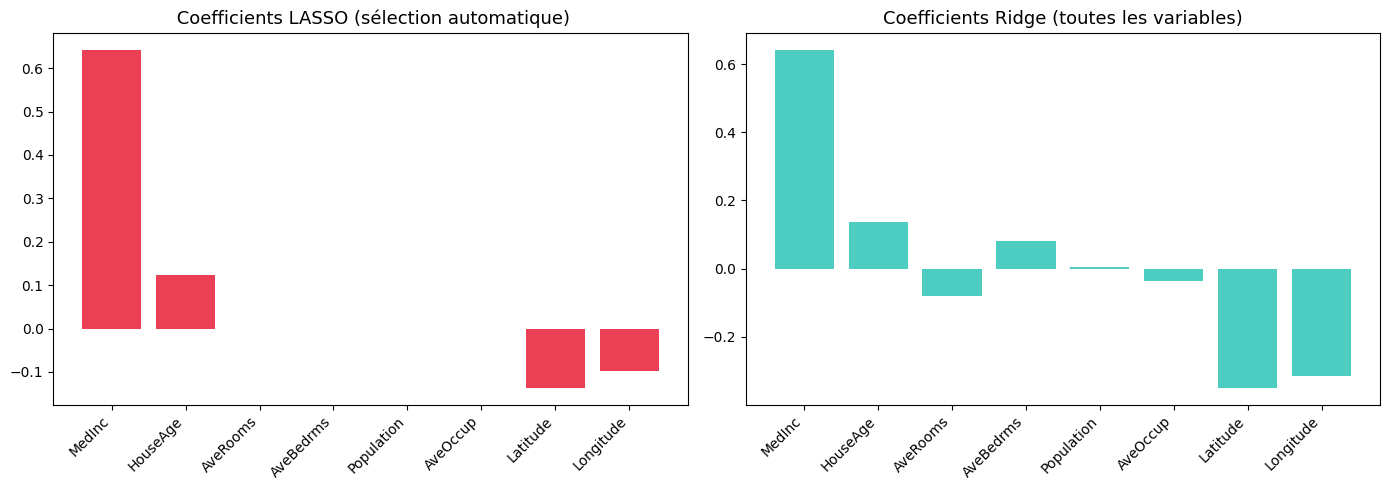

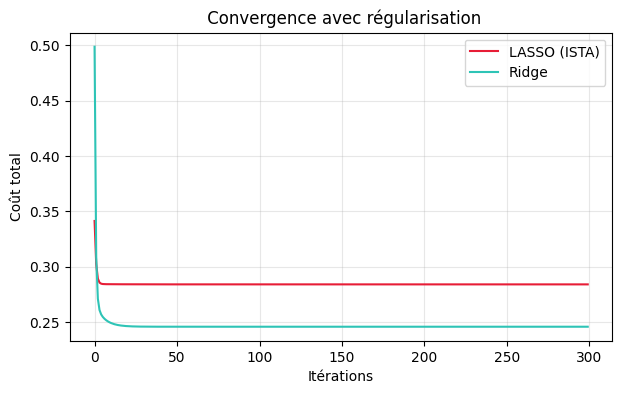

In [26]:
def soft_threshold(z, mu):
    return np.sign(z) * np.maximum(np.abs(z) - mu, 0.0)

def ista_custom(X, y, lam, alpha, max_iter=300):
    w = np.zeros(X.shape[1])
    losses = []
    for _ in range(max_iter):
        grad = (X.T @ (X @ w - y)) / len(X)
        w = soft_threshold(w - alpha * grad, alpha * lam)
        loss = 0.5 * np.mean((X @ w - y)**2) + lam * np.sum(np.abs(w))
        losses.append(loss)
    return w, losses

def ridge_gd_custom(X, y, lam, alpha, max_iter=300):
    w = np.zeros(X.shape[1])
    losses = []
    for _ in range(max_iter):
        pred = X @ w
        loss = 0.5 * np.mean((pred - y)**2) + 0.5 * lam * np.sum(w**2)
        losses.append(loss)
        grad = (X.T @ (pred - y)) / len(X) + lam * w
        w -= alpha * grad
    return w, losses

w_ista, loss_ista = ista_custom(X_train, y_train, lam=0.05, alpha=alpha_opt)
w_ridge, loss_ridge = ridge_gd_custom(X_train, y_train, lam=0.1, alpha=alpha_opt)

# Sparsité
print(f"\n LASSO : {np.sum(np.abs(w_ista) > 1e-4)} variables actives sur {d}")
print(f" Ridge : toutes les {d} variables sont utilisées")

# Visualisation coefficients
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(range(d), w_ista, color='#E71D36', alpha=0.85)
plt.xticks(range(d), data.feature_names, rotation=45, ha='right')
plt.title(" Coefficients LASSO (sélection automatique)", fontsize=13)

plt.subplot(1, 2, 2)
plt.bar(range(d), w_ridge, color='#2EC4B6', alpha=0.85)
plt.xticks(range(d), data.feature_names, rotation=45, ha='right')
plt.title("Coefficients Ridge (toutes les variables)", fontsize=13)
plt.tight_layout()
plt.show()

# Convergence régularisation
plt.figure(figsize=(7, 4))
plt.plot(loss_ista, color='#E71D36', label='LASSO (ISTA)')
plt.plot(loss_ridge, color='#2EC4B6', label='Ridge')
plt.xlabel("Itérations")
plt.ylabel("Coût total")
plt.title(" Convergence avec régularisation")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# ***ÉVALUATION FINALE SUR VALIDATION***

In [27]:
def mse(y_true, y_pred): return np.mean((y_true - y_pred)**2)

results = {
    "Descente de gradient": mse(y_val, X_val @ w_gd),
    "Gradient conjugué":    mse(y_val, X_val @ w_cg),
    "SGD + Momentum":       mse(y_val, X_val @ w_mom),
    "LASSO (ISTA)":         mse(y_val, X_val @ w_ista),
    "Ridge":                mse(y_val, X_val @ w_ridge)
}

print("\n" + "="*50)
print(" PERFORMANCE SUR VALIDATION (MSE)")
print("="*50)
for name, err in results.items():
    print(f"{name:22s} → {err:.5f}")


 PERFORMANCE SUR VALIDATION (MSE)
Descente de gradient   → 0.41698
Gradient conjugué      → 0.41693
SGD + Momentum         → 0.41705
LASSO (ISTA)           → 0.48846
Ridge                  → 0.44925
